### Initialization
Installing requirements, auto reload changing to code, imports and some configurations

In [1]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

import sys
sys.path.append('..')

from helpers import utils, pipelines, models

from sklearn.model_selection import train_test_split

import multiprocessing

from data_augmentaion.data_augmentator import DataAugmentor 

import json

import time

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [4]:
# disable tqdm progress bar by default
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

### Define research parameters

In [5]:
regression_task = False
# continuous_features = []
# metric = 'accuracy'
metrics = ['f1_weighted', 'accuracy', 'balanced_accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted'] 

test_size_proportion = 0.2
augment_sample = 0.5

search_pipelines = pipelines.get_classification_pipelines()
search_parameters = models.parameters

settings = [
    {'method': 'random'},
    {'method': 'smote'},
    {'method': 'cf_random'},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 1}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 1}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 1}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 0.2}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 1}},
]

In [6]:
raw_data = pd.read_csv(r"../datasets/cirrhosis.csv")
df = utils.preprocess_cirrhosis(raw_data)
target = 'Status'

#### split data

In [7]:
# all data
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_proportion, random_state=42)

In [8]:
continuous_features = X.select_dtypes(include=['number']).columns.tolist()
continuous_features

['N_Days',
 'Age',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Stage']

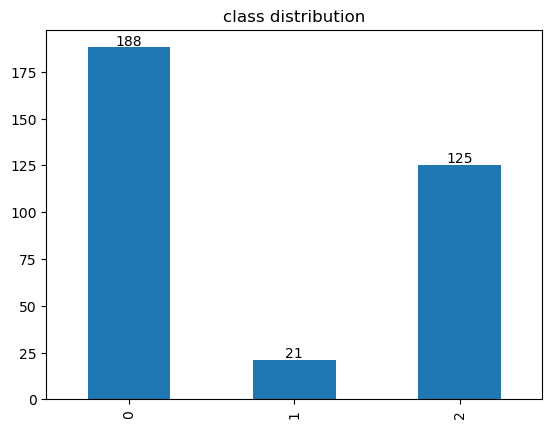

In [9]:
ax = y_train.value_counts().sort_index().plot(kind='bar')
ax.set_title('class distribution')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()-4), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [10]:
full_results_df = pd.DataFrame()

### Whole dataset scores

In [11]:
print(f'whole dataset scores:')
_, whole_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
whole_dataset_result_df = pd.DataFrame.from_dict(whole_scores, orient='index')
whole_dataset_result_df.columns = pd.MultiIndex.from_product([['whole']] + [whole_dataset_result_df.columns])
display(whole_dataset_result_df.T)

whole dataset scores:


lg        rf       xgb
whole f1_weighted           0.731732  0.773441  0.742029
      accuracy              0.738095  0.797619  0.761905
      balanced_accuracy     0.524411  0.547980  0.528620
      precision_weighted    0.714340  0.776045  0.727952
      recall_weighted       0.738095  0.797619  0.761905
      roc_auc_ovr_weighted  0.871974  0.860169  0.867857
      roc_auc_ovo_weighted  0.839075  0.797379  0.837963

In [12]:
full_results_df = pd.concat([full_results_df, whole_dataset_result_df], axis=1)

### little flattening the y-curve
randomly oversampling rare clasess to accelerate augmentation 

In [13]:
X_train_inflate, y_train_inflate = utils.infalte_randomly(X_train, y_train)

In [14]:
print(f'inflate dataset scores:')
_, inflate_scores = utils.fit_and_evaluate(X_train_inflate, y_train_inflate, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
inflate_dataset_result_df = pd.DataFrame.from_dict(inflate_scores, orient='index')
inflate_dataset_result_df.columns = pd.MultiIndex.from_product([['inflate']] + [inflate_dataset_result_df.columns])
display(inflate_dataset_result_df.T)

inflate dataset scores:


lg        rf       xgb
inflate f1_weighted           0.724538  0.736318  0.767543
        accuracy              0.726190  0.761905  0.773810
        balanced_accuracy     0.526094  0.521886  0.611953
        precision_weighted    0.699905  0.750024  0.778712
        recall_weighted       0.726190  0.761905  0.773810
        roc_auc_ovr_weighted  0.880506  0.860962  0.878423
        roc_auc_ovo_weighted  0.862975  0.853731  0.872099

In [15]:
# full_results_df = pd.concat([full_results_df, inflate_dataset_result_df], axis=1)

In [16]:
# full_results_df

### running experiments

In [17]:
best_estimators = {}
best_scores = {}
total_time = time.time()
for i, s in enumerate(settings):
    start = time.time()
    print(f'{i+1} / {len(settings)}, {s}', end=' ')

    if 'cf' in s['method']:
        X_train_for_balance_augmemt, y_train_for_balance_augmemt = X_train_inflate, y_train_inflate
    else:
        X_train_for_balance_augmemt, y_train_for_balance_augmemt = X_train, y_train
    augmentor = DataAugmentor(X_train_for_balance_augmemt, y_train_for_balance_augmemt, X_test, y_test,
                             method=s['method'], regression=regression_task,
                             continuous_feats=continuous_features,
                             cf_scoring='balanced_accuracy',
                             kw_args=s.get('kw_args', {})
                             )

    X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
    best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
    utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_test, y_test,
                            search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'], orient='index')
    result_df_balanced.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])} balanced']] + [result_df_balanced.columns])
    # result_df_balanced.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))} balanced']] + [result_df_balanced.columns])


    X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)
    best_estimators[f'{i}'], best_scores[f'{i}'] = \
        utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_test, y_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df = pd.DataFrame.from_dict(best_scores[f'{i}'], orient='index')
    result_df.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])}']] + [result_df.columns])
    # result_df.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))}']] + [result_df.columns])


    full_results_df = pd.concat([full_results_df, result_df_balanced, result_df], axis=1)
    print(f'{time.time() - start} seconds for settings {i}')

print(f'\nTotal time: {time.time() - total_time}')

1 / 4, {'method': 'random'} 15.416136741638184 seconds for settings 0
2 / 4, {'method': 'smote'} 10.61282467842102 seconds for settings 1
3 / 4, {'method': 'cf_random'} model for cf balanced_accuracy score: {'cf': {'balanced_accuracy': 0.638047138047138}}
0/63
50/63
0/138
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
50/138
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
100/138
model for cf balanced_accuracy score: {'cf': {'balanced_accuracy': 0.638047138047138}}
0/181
50/181
No Counterfactuals found for the given configuration, perhaps try with different parameters... ;

### Summary

In [18]:
full_results_df

whole                                                 \
    f1_weighted  accuracy balanced_accuracy precision_weighted   
lg     0.731732  0.738095          0.524411           0.714340   
rf     0.773441  0.797619          0.547980           0.776045   
xgb    0.742029  0.761905          0.528620           0.727952   

                                                              random balanced  \
    recall_weighted roc_auc_ovr_weighted roc_auc_ovo_weighted     f1_weighted   
lg         0.738095             0.871974             0.839075        0.706092   
rf         0.797619             0.860169             0.797379        0.768157   
xgb        0.761905             0.867857             0.837963        0.756261   

                                                                    \
     accuracy balanced_accuracy precision_weighted recall_weighted   
lg   0.702381          0.648990           0.734385        0.702381   
rf   0.750000          0.675926           0.795604        0.750000   
xgb  0.750000          0.596801           0.764646        0.750000   

                                                   random            \
    roc_auc_ovr_weighted roc_auc_ovo_weighted f1_weighted  accuracy   
lg              0.868155             0.865260    0.743414  0.761905   
rf              0.877331             0.884861    0.786152  0.809524   
xgb             0.861806             0.831034    0.729809  0.750000   

                                                                               \
    balanced_accuracy precision_weighted recall_weighted roc_auc_ovr_weighted   
lg           0.533670           0.726089        0.761905             0.868750   
rf           0.557239           0.791980        0.809524             0.852232   
xgb          0.519360           0.717605        0.750000             0.841071   

                         smote balanced                              \
    roc_auc_ovo_weighted    f1_weighted  accuracy balanced_accuracy   
lg              0.830312       0.662661  0.642857          0.607744   
rf              0.801512       0.758927  0.761905          0.609428   
xgb             0.784692       0.756198  0.738095          0.670875   

                                                             \
    precision_weighted recall_weighted roc_auc_ovr_weighted   
lg            0.719057        0.642857             0.856647   
rf            0.757116        0.761905             0.858333   
xgb           0.767474        0.738095             0.846825   

                               smote                              \
    roc_auc_ovo_weighted f1_weighted  accuracy balanced_accuracy   
lg              0.849883    0.662661  0.642857          0.607744   
rf              0.844441    0.758927  0.761905          0.609428   
xgb             0.840834    0.756198  0.738095          0.670875   

                                                             \
    precision_weighted recall_weighted roc_auc_ovr_weighted   
lg            0.719057        0.642857             0.856647   
rf            0.757116        0.761905             0.858333   
xgb           0.767474        0.738095             0.846825   

                         cf_random balanced                              \
    roc_auc_ovo_weighted        f1_weighted  accuracy balanced_accuracy   
lg              0.849883           0.713028  0.702381          0.647306   
rf              0.844441           0.715665  0.678571          0.620370   
xgb             0.840834           0.759039  0.761905          0.607744   

                                                             \
    precision_weighted recall_weighted roc_auc_ovr_weighted   
lg            0.740344        0.702381             0.865327   
rf            0.780154        0.678571             0.870833   
xgb           0.756864        0.761905             0.865625   

                           cf_random                              \
    roc_auc_ovo_weighted f1_weighted  accuracy balanced_accuracy   
lg 

In [19]:
print('best methods:')
display(utils.get_best_methods(full_results_df))

best methods:


,f1_weighted,accuracy,balanced_accuracy,precision_weighted,recall_weighted,roc_auc_ovr_weighted,roc_auc_ovo_weighted
lg,random,random,cf_genetic balanced,cf_genetic balanced,random,cf_genetic,cf_genetic
rf,random,random,random balanced,cf_random,random,random balanced,random balanced
xgb,cf_random balanced,whole,smote balanced,smote balanced,whole,cf_genetic,cf_genetic
overall,random,random,random balanced,cf_random,random,cf_genetic,random balanced


In [20]:
utils.save_results_as_latex_tables(full_results_df, task_name="cirrhosis")

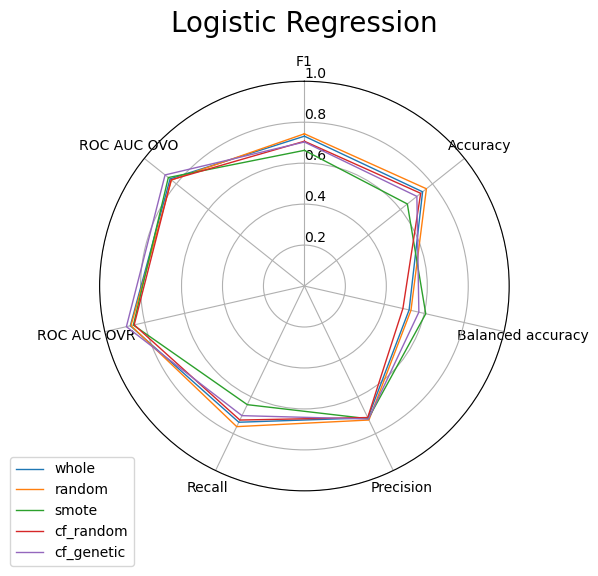

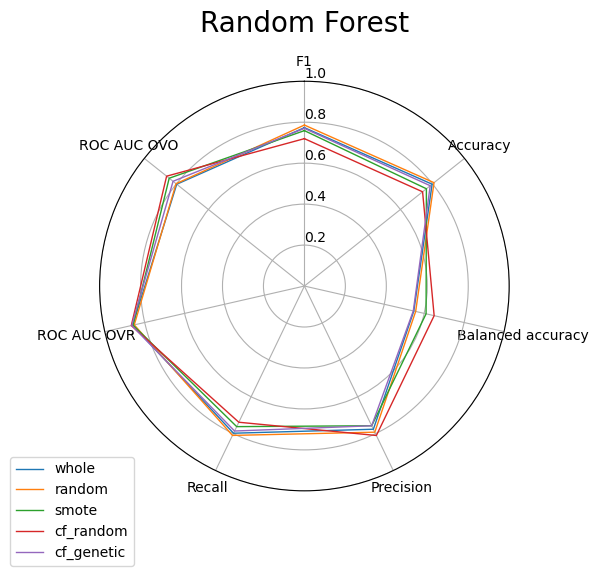

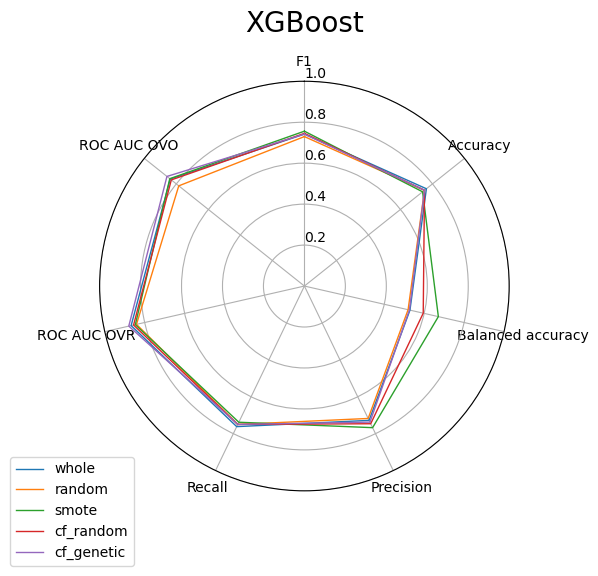

In [21]:
wanted_cols = ['whole', 'random','smote','cf_random','cf_genetic']
metric_names = {'f1_weighted': 'F1',
                'accuracy': 'Accuracy',
                'balanced_accuracy': 'Balanced accuracy',
                'precision_weighted': 'Precision',
                'recall_weighted': 'Recall',
                'roc_auc_ovr_weighted': 'ROC AUC OVR',
                'roc_auc_ovo_weighted': 'ROC AUC OVO'}
utils.spider_plot(full_results_df, 'lg', wanted_cols, metric_names, 'Logistic Regression', save_task_name='cirrhosis')
utils.spider_plot(full_results_df, 'rf', wanted_cols, metric_names, 'Random Forest', save_task_name='cirrhosis')
utils.spider_plot(full_results_df, 'xgb', wanted_cols, metric_names, 'XGBoost', save_task_name='cirrhosis')

In [22]:
full_results_df.to_csv(rf'../log/experiment_multiclass_cirrhosis_testsize{test_size_proportion}_augmentsample{augment_sample}.csv')